In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kaggle-survey-2021/kaggle_survey_2021_responses.csv
/kaggle/input/kaggle-survey-2021/supplementary_data/kaggle_survey_2021_methodology.pdf
/kaggle/input/kaggle-survey-2021/supplementary_data/kaggle_survey_2021_answer_choices.pdf


In [2]:
# load dataset
data = pd.read_csv("../input/kaggle-survey-2021/kaggle_survey_2021_responses.csv", low_memory = False)

In [3]:
# first five rows
data.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor..."
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


In [4]:
# size of the dataset
data.shape # 25973 rows, 369 columns

(25974, 369)

In [5]:
def rename_columns(df):
    """
    input: the dataset we want to rename the columns
    output: combine the first row of the dataset into the original column
    """
    original_columns = df.columns
    num_col = df.shape[1]
    first_row = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data below the first row
    # create a list containing new column names
    new_cols = []
    for col in range(num_col):
        new_col_name = original_columns[col] + '_' + first_row[col]
        new_cols.append(new_col_name)
    df.columns = new_cols # assign the new column names to the dataset
    return df

In [6]:
renamed_data = rename_columns(data)

In [7]:
def subset_data(df, col, criteria):
    """
    input:
    df: the dataset we want to subset from
    col: target columns as the filter
    criteria: value to feed the filter
    
    output:
    a new dataset which is a subset of the original one
    """
    
    new_df = df.loc[df[col] == criteria]
    
    return new_df

ds_data = subset_data(renamed_data, 
           'Q5_Select the title most similar to your current role (or most recent title if retired): - Selected Choice',
           'Data Scientist')

In [8]:
# We have 3616 data scientists contributing to this survey
ds_data.shape

(3616, 369)

In [9]:
def question_columns(df, query, method = 'strict'):
    """
    input: 
    df - target dataset
    query - str, query we want to find relevant infomation in the dataset. e.g. 'Q7', or 'machine learning' 
    
    output:
    a subset of data which include the columns of the query in interest
    
    method:
    if it == strict, which means we will look for the question exactly EQUALS to the query. e.g. if we search 'age', then 'language' won't
    be taken into account in this case;
    
    if it == loose, which means we will look for the question exactly CONTAINS the query. e.g. if we search 'age', then 'language' will
    be taken into account in this case.
    """
    columns = df.columns
    question_col = []
    for col in columns:
        if method == 'strict':
            col_parts = col.lower().split() # each column name will be separated into single word tokens at first
            if query.lower() in col_parts:
                question_col.append(col)
        elif method == 'loose':
            if query.lower() in col.lower():
                question_col.append(col)
    return df[question_col]

In [10]:
role_question = question_columns(ds_data, 'role')

In [11]:
array = np.where(role_question.isnull(),0,1)

In [12]:
pd.DataFrame(data=array, columns=role_question.columns)

,Q5_Select the title most similar to your current role (or most recent title if retired): - Selected Choice,Q24_Part_1_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,"Q24_Part_2_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Q24_Part_3_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Q24_Part_4_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,Q24_Part_5_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Experimentation and iteration to improve existing ML models,Q24_Part_6_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Q24_Part_7_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,Q24_OTHER_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other
0,1,0,1,1,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0
2,1,0,1,0,0,0,0,0,0
3,1,1,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
3611,1,1,0,1,0,0,1,0,0
3612,1,1,1,1,1,1,1,0,0
3613,1,1,1,1,1,1,1,0,0
3614,1,1,0,0,1,0,1,0,0


In [13]:
def replace_nan(df):
    """
    input:
    df - the target dataset
    
    output:
    a new dataset with nan values replaced as 0 and non-nan values replaced with 1
    """
    array = np.where(df.isnull(),0,1)
    df = pd.DataFrame(data=array, columns=df.columns)
    
    return df


role_data = replace_nan(role_question)

## What questions we want to ask here?
1. How many types of data scientists based on activity they usually do?
2. Which skill each type emphasizes at?
3. Which platform/tools each type emphazies at?
4. Demographic segmentation of each type?
5. Profession segmentation of each type?

In [14]:
feature_data = role_data.iloc[: , 1:]

In [15]:
def kmeans_cluster_opt(df, init = 'k-means++', max_num_cluster = 9):
    """
    input: 
    df - the dataset we want to segments into cluster
    init - the way we want to initialize the starting centroid
    max_num_cluster - the max number of cluster
    
    output:
    a visualization showing the line graph indicating the optimal number of klusters, based on inertias value
    """
    num_clusters = list(range(1, max_num_cluster))
    inertias = []

    for k in num_clusters:
        model = KMeans(init=init, n_clusters=k, random_state = 42)
        model.fit(df)
        inertias.append(model.inertia_)

    
    plt.plot(num_clusters, inertias, '-o')

    plt.xlabel('number of clusters (k)')
    plt.ylabel('inertia')

    plt.show()

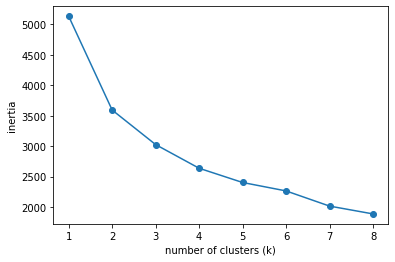

In [16]:
kmeans_cluster_opt(feature_data)

In [17]:
def kmeans_predict(df, init = 'k-means++', n_clusters = 4):
    """
    input:
    df - dataset we want to segment into clusters
    init - the way we want to initialize the starting centroid
    n_clusters - the number of cluster
    
    output:
    return an array of predictions on the cluster label of given features
    """
    model = KMeans(init=init, n_clusters = n_clusters, random_state = 42)

    model.fit(df)

    labels = model.predict(df)
    
    return labels

In [18]:
kmeans_predict(feature_data, n_clusters = 3)

array([1, 2, 1, ..., 0, 2, 1], dtype=int32)

In [19]:
feature_data['cluster'] = kmeans_predict(feature_data, n_clusters = 3)

In [20]:
feature_data.groupby(['cluster']).sum()

,Q24_Part_1_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,"Q24_Part_2_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Q24_Part_3_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,Q24_Part_4_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,Q24_Part_5_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Experimentation and iteration to improve existing ML models,Q24_Part_6_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,Q24_Part_7_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,Q24_OTHER_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other
cluster,,,,,,,,
0,1282,752,1297,1112,1206,594,0,5
1,0,123,160,104,111,96,165,94
2,1169,374,299,142,122,157,0,6


In [21]:
pca = PCA()
components = pca.fit(feature_data).components_
components = pd.DataFrame(components).transpose()
components.index =  feature_data.columns
print(components)

                                                           0         1  \
Q24_Part_1_Select any activities that make up a...  0.076308  0.696827   
Q24_Part_2_Select any activities that make up a...  0.154308  0.466492   
Q24_Part_3_Select any activities that make up a...  0.336313  0.244953   
Q24_Part_4_Select any activities that make up a...  0.324245  0.152645   
Q24_Part_5_Select any activities that make up a...  0.357395  0.089629   
Q24_Part_6_Select any activities that make up a...  0.163018  0.129903   
Q24_Part_7_Select any activities that make up a... -0.027596 -0.133963   
Q24_OTHER_Select any activities that make up an... -0.015251 -0.066730   
cluster                                            -0.772544  0.407686   

                                                           2         3  \
Q24_Part_1_Select any activities that make up a... -0.312108 -0.283258   
Q24_Part_2_Select any activities that make up a...  0.754618  0.363458   
Q24_Part_3_Select any activities that

In [22]:
components

,0,1,2,3,4,5,6,7,8
Q24_Part_1_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Analyze and understand data to influence product or business decisions,0.076308,0.696827,-0.312108,-0.283258,0.134127,-0.131314,-0.542309,-0.000630,0.040375
"Q24_Part_2_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",0.154308,0.466492,0.754618,0.363458,-0.145453,-0.188542,0.007415,0.012598,0.010290
Q24_Part_3_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build prototypes to explore applying machine learning to new areas,0.336313,0.244953,-0.128518,-0.274817,-0.681655,0.386609,0.323763,0.091046,0.087286
Q24_Part_4_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Build and/or run a machine learning service that operationally improves my product or workflows,0.324245,0.152645,0.191386,-0.273511,0.692085,0.371752,0.361045,0.084320,0.074044
Q24_Part_5_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Experimentation and iteration to improve existing ML models,0.357395,0.089629,-0.375683,0.183901,0.077829,-0.664523,0.472130,0.105521,0.087108
Q24_Part_6_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Do research that advances the state of the art of machine learning,0.163018,0.129903,-0.351303,0.774323,0.099081,0.462325,-0.098821,0.006411,0.013911
Q24_Part_7_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - None of these activities are an important part of my role at work,-0.027596,-0.133963,0.056864,0.020626,-0.009358,-0.006932,-0.193465,0.895203,0.372398
Q24_OTHER_Select any activities that make up an important part of your role at work: (Select all that apply) - Selected Choice - Other,-0.015251,-0.066730,0.030243,0.013651,-0.003736,-0.006124,-0.043526,-0.401428,0.911659
cluster,-0.772544,0.407686,-0.106279,0.057650,0.035246,0.064205,0.445728,0.103596,0.087052


In [23]:
var_ratio = pca.explained_variance_ratio_
var_ratio = pd.DataFrame(var_ratio).transpose()
var_ratio

,0,1,2,3,4,5,6,7,8
0,0.50656,0.154952,0.082188,0.074253,0.068364,0.057696,0.026801,0.017915,0.011271
